<h1><center>MNIST classification using Numpy<center></h1>

 **Louis PERSONNAZ**
    
 **Timothée LY**

## Importing Numpy and Keras

In [48]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

print(f"Using tensorflow version {tf.__version__}")
print(f"Using keras version {keras.__version__}")

Using tensorflow version 2.8.0
Using keras version 2.8.0


## Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets. Check the size of the training and testing sets. 

In [49]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g. ImageNet)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Training set size :", X_train.shape, "\nTest set size :", X_test.shape)

Training set size : (60000, 28, 28) 
Test set size : (10000, 28, 28)


The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the first sample of the training set.

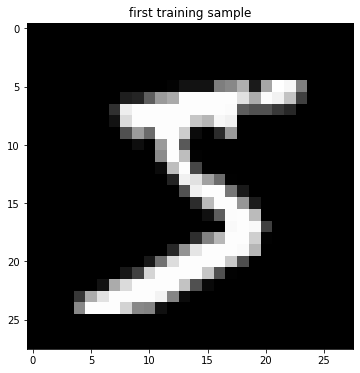

In [50]:
# Let us visualize the first training sample using the Matplotlib library
plt.figure(figsize = (6, 6))
plt.imshow(X_train[0], cmap='gray')
plt.title("first training sample")
plt.show()

The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output of our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want the true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one-hot label (careful, $0$ will be the first digit): 
$$\mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

In [51]:
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot  = to_categorical(y_test, num_classes=10)

Images are black and white, with size $(28, 28)$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```.

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

In [52]:
train_images = X_train
test_images = X_test

# Reshape to proper images with 1 color channel according to backend scheme
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape(-1, img_rows*img_cols)
test_images = test_images.reshape(-1, img_rows*img_cols)
print(f"Shape of train images array: {train_images.shape}")
print(f"Shape of test images array: {train_images.shape}")

# Cast pixels from uint8 to float32
train_images = train_images.astype(np.float32)

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time?
scaler = StandardScaler(copy=False)
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

Shape of train images array: (60000, 784)
Shape of test images array: (60000, 784)


# Working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

## Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there are $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target `one_hot` vector. 

Here, you first need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.

In [53]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with one layer 
def initLayer(n_input, n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs:  n_input: the number of input units   - int
             n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
             b: a vector bias for the layer       - numpy ndarray
             nb_params: the number of parameters  - int
    """
    W = np.random.normal(size=(img_rows*img_cols, n_output))
    b = np.zeros(n_output)
    nb_params = img_rows*img_cols*n_output + n_output
    return W, b, nb_params

In [54]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs:  W: the weights - numpy ndarray
             b: the bias    - numpy ndarray
             X: the batch   - numpy ndarray
    Outputs: z: outputs     - numpy ndarray
    """
    z = X @ W + b 
    return z

## Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:
$$ \frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(-c) \exp(z_i)}{\exp(-c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}$$
what trick can we use to ensure we will not encounter any overflow? 

In [55]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs:  z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values   - numpy ndarray
    """
    damping = np.max(z)
    z = z - damping
    out = np.exp(z) / np.sum(np.exp(z))
    return out

We use a damping factor corresponding to the maximum value of the scores, in that way, the exponential factor cannot overflow.

## Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} - \eta \nabla_{\mathbf{W}} l_{MLE} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: the gradient $\nabla_{\mathbf{W}} l_{MLE}$ is the matrix containing the partial derivatives 
$$ \left[\frac{\partial l_{MLE}}{\partial W_{ij}}\right]_{i=1..784,\,j=1..10} $$
**Remark**: Careful, the usual way of implementing this in Python has the dimensions of $\mathbf{W}$ reversed compared to the notation of the slides.

Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} - \eta \frac{\partial l_{MLE}}{\partial W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\partial l_{MLE}}{\partial W_{ij}} = \frac{\partial l_{MLE}}{\partial z_{j}} \frac{\partial z_j}{\partial W_{ij}}$$ 

It's easy to compute that $\frac{\partial z_j}{\partial W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\partial l_{MLE}}{\partial z_{j}} = o_j - y_j$ and we obtain that $$\frac{\partial l_{MLE}}{\partial W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. Noting $\nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{MLE}$ (`grad_w`) and $\nabla_{\mathbf{b}} l_{MLE}$ (`grad_b`) in order to call the function ```updateParams```.

Note: the regularizer and the `weight_decay` $\lambda$ are used in ```updateParams```.

In [56]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs:  eta: the step-size of the gradient descent - float 
             W: the weights - ndarray
             b: the bias -  ndarray
             grad: the gradient of the activations w.r.t. the loss -  list of ndarray
             X: the data -  ndarray
             regularizer: 'L2' or None - the regularizer to be used in updateParams
             weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
             b: the bias updated -  ndarray
    """
    X = X.reshape(img_rows*img_cols, 1)
    grad = grad.reshape(1, -1)
    
    grad_w = X @ grad
    grad_b = grad
        
    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    
    return W, b

The update rule is affected by the regularization. We implement two cases: no regularization, or L2 regularization. Use the two possible update rules to implement the following function:

We consider the regularized loss $l_{reg}(\mathbf{W}) = l_{MLE}(\mathbf{W}) + \frac{\lambda}{2} \mathbf{W}^\top \mathbf{W}$ for which the update rule becomes $\mathbf{W}^{t+1} \leftarrow \mathbf{W}^t - \eta ( \nabla_{\mathbf{W}} l_{MLE} + \lambda \mathbf{W}^t )$

In [57]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0):
    """
    Perform the update of the parameters
    Inputs:  param: the network parameters - ndarray
             grad_param: the updates of the parameters - ndarray
             eta: the step-size of the gradient descent - float
             weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer is None:
        return param - eta * grad_param 
    elif regularizer == 'L2':
        return  (1 - eta*weight_decay)*param - eta * grad_param 
    else:
        raise NotImplementedError

## Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.

In [58]:
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs:  act_func: the activation function - function
             W: the weights - list of ndarray
             B: the bias - list of ndarray
             X: the batch - ndarray
             labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
             accuracy: the ratio of examples that are well-classified - float
    """ 
    ### Forward propagation
    z = forward(W, b, X)
 
    ### Compute the softmax and the prediction
    out = softmax(z)
    pred = np.argmax(z, axis=1)
    real = np.argmax(labels, axis=1)
    
    ### Compute the accuracy
    accuracy = np.mean(pred==real)
    return accuracy

## Preparing training

The following hyperparameters are given. Next, we can assemble all the functions previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will consider each training example once.

In [59]:
# Optimization
eta = 0.01
regularizer = 'L2'
weight_decay = 0.0001

# Training
log_interval = 5000

In [60]:
n_training = train_images.shape[0] 
n_features = img_rows*img_cols
n_labels = 10
W, b, nb_params = initLayer(n_features, n_labels)

In [61]:
# Data structures for plotting
g_train_acc = []
g_valid_acc = []

######################
## Learning process ##
######################
for j in range(n_training):
    ### Getting the example
    X, y = train_images[j], y_train_one_hot[j]

    ### Forward propagation
    z = forward(W, b, X)

    ### Compute the softmax
    out = softmax(z)
        
    ### Compute the gradient at the top layer
    derror = out - y # this is o - y 

    ### Update the parameters
    W, b = update(eta, W, b, derror, X, regularizer, weight_decay)

    if j % log_interval == 0:
        ### Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, train_images, y_train_one_hot) 

        ### And the testing accuracy
        test_accuracy = computeAcc(W, b, test_images, y_test_one_hot) 

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)
        print(f"step={j:<7}: train_acc={train_accuracy:.4f}, test_acc={test_accuracy:.4f}, eta={eta}")

g_train_acc.append(train_accuracy)
g_valid_acc.append(test_accuracy)
print(f"Final result: train_acc={train_accuracy:.4f}, test_acc={test_accuracy:.4f}, eta={eta}") 

step=0      : train_acc=0.0837, test_acc=0.0724, eta=0.01
step=5000   : train_acc=0.7997, test_acc=0.8030, eta=0.01
step=10000  : train_acc=0.8369, test_acc=0.8404, eta=0.01
step=15000  : train_acc=0.8502, test_acc=0.8525, eta=0.01
step=20000  : train_acc=0.8671, test_acc=0.8679, eta=0.01
step=25000  : train_acc=0.8675, test_acc=0.8691, eta=0.01
step=30000  : train_acc=0.8757, test_acc=0.8733, eta=0.01
step=35000  : train_acc=0.8807, test_acc=0.8799, eta=0.01
step=40000  : train_acc=0.8833, test_acc=0.8796, eta=0.01
step=45000  : train_acc=0.8874, test_acc=0.8840, eta=0.01
step=50000  : train_acc=0.8784, test_acc=0.8762, eta=0.01
step=55000  : train_acc=0.8875, test_acc=0.8843, eta=0.01
Final result: train_acc=0.8875, test_acc=0.8843, eta=0.01


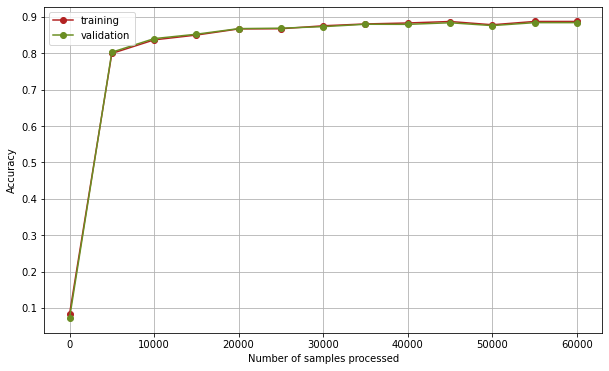

In [62]:
fig = plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, n_training+1, log_interval), g_train_acc, c='firebrick', marker='o', label="training")
plt.plot(np.arange(0, n_training+1, log_interval), g_valid_acc, c='olivedrab', marker='o', label="validation")
plt.xlabel("Number of samples processed")
plt.ylabel("Accuracy")
plt.grid()
plt.legend(loc="best")
plt.show()

# Working with TensorFlow

Let's try to do the same using TensorFlow and the keras API!

In [63]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import L2

In [64]:
input_layer = Input(shape=(n_features,), name="input")
output_layer = Dense(n_labels,
                     use_bias=True,
                     activation="softmax",
                     kernel_regularizer=L2(l2=weight_decay),
                     bias_regularizer=None,
                     name="output")

simple_model = keras.Sequential([input_layer, output_layer], name='simple_model')

simple_model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [65]:
print(f"Theoretical number of trainable params: {nb_params}")

Theoretical number of trainable params: 7850


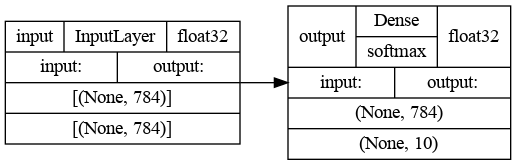

In [66]:
plot_model(simple_model, rankdir='LR', show_shapes=True, show_dtype=True, show_layer_activations=True)

In [67]:
simple_model.compile(optimizer=SGD(learning_rate=eta),
                     loss='mse',
                     metrics=["categorical_accuracy"])

In [68]:
batch_size = 1
epochs = 1
history = simple_model.fit(train_images,
                           y_train_one_hot,
                           epochs=epochs,
                           batch_size=batch_size,
                           shuffle=False,
                           validation_data=(test_images, y_test_one_hot))

60000/60000 [==============================] - 59s 982us/step - loss: 0.0216 - categorical_accuracy: 0.8725 - val_loss: 0.0161 - val_categorical_accuracy: 0.9097


We get a similar behaviour though the final test accuracies differ a bit (this may come from the random initialized parameters).